In [1]:
from fastai import *
from fastai.vision import *
from fastai.widgets import DatasetFormatter, ImageDeleter, ImageRelabeler

In [2]:
folderNames = []

path = 'data/urls/'
 
files = os.listdir(path)
for name in files:
    folderNames.append(os.path.splitext(name)[0])

pathI = Path('data/images')

for title in folderNames:
    dest = pathI/title
    filename = title + '.txt'
    dest.mkdir(parents=True, exist_ok=True)
    #download_images('data/urls/' + filename, dest, max_pics=200,max_workers=0)
    

In [3]:
classes = ['elephants','mammoths']

for c in classes:
    print(c)
    verify_images(pathI/c, delete=True, max_workers=8)

elephants


mammoths


## Train model

np.random.seed(42)
data = ImageDataBunch.from_folder(pathI, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=100, num_workers=4).normalize(imagenet_stats)

data.classes, data.c, len(data.train_ds), len(data.valid_ds)

learn = create_cnn(data, models.resnet50, metrics=accuracy, model_dir="../model")

learn.fit_one_cycle(10)

In [4]:
np.random.seed(42)
data = ImageDataBunch.from_folder(pathI, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=100, num_workers=4).normalize(imagenet_stats)

data.classes, data.c, len(data.train_ds), len(data.valid_ds)

learn = create_cnn(data, models.resnet34, metrics=accuracy, model_dir="../model")

learn.fit_one_cycle(1)

Total time: 00:08
epoch  train_loss  valid_loss  accuracy
1      0.972744    0.974284    0.600000  (00:08)



In [5]:
len(data.valid_ds)

45

In [6]:
learn.save('stage-1', return_path=True)

PosixPath('data/images/../model/stage-1.pth')

In [7]:
learn.unfreeze()

learn.lr_find()

learn.recorder.plot()

In [8]:
learn.load('stage-1')

ClassificationLearner(data=<fastai.vision.data.ImageDataBunch object at 0x7f066764eb00>, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1

In [9]:
learn.fit_one_cycle(1, max_lr=slice(8e-5,2e-4))

Total time: 00:07
epoch  train_loss  valid_loss  accuracy
1      0.568237    0.472258    0.800000  (00:07)



learn.load('stage-1')

## Interpretation

In [10]:
learn.save('stage-2')

In [11]:
learn.load('stage-2')

ClassificationLearner(data=<fastai.vision.data.ImageDataBunch object at 0x7f066764eb00>, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

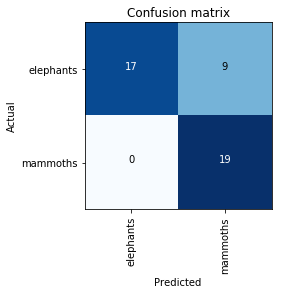

In [13]:
interp.plot_confusion_matrix()

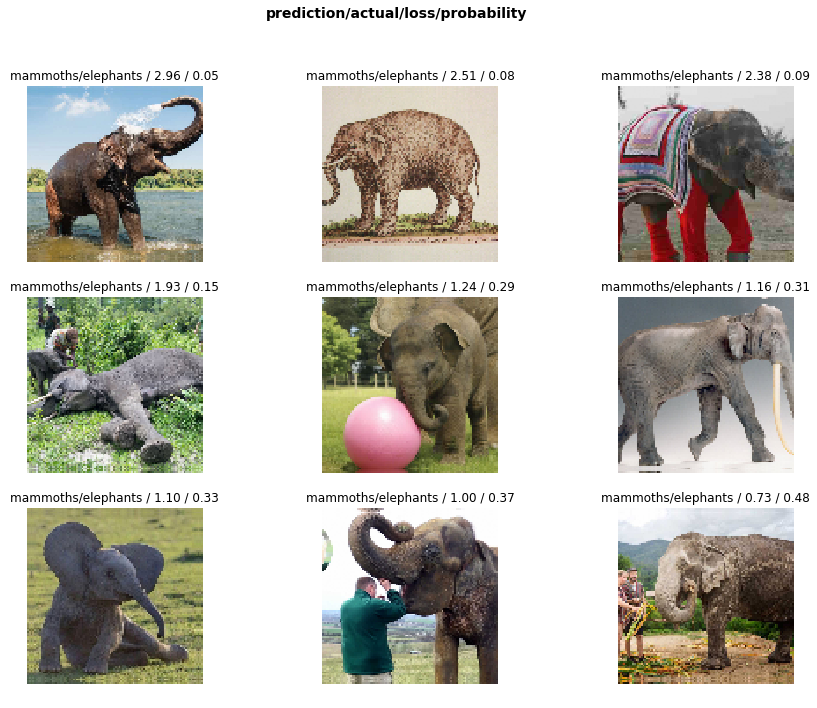

In [14]:
interp.plot_top_losses(9, figsize=(15,11))

In [15]:
interp.most_confused(min_val=1)

[('elephants', 'mammoths', 9)]

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `FileDeleter` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

First we need to get the file paths from our top_losses. Here's a handy function that pulls out all our top_losses:

In [16]:
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

Now we can pass in these paths to our widget.

In [17]:
ImageDeleter(ds, idxs)

Flag photos for deletion by clicking 'Delete'. Then click 'Confirm' to delete flagged photos and keep the rest in that row. The `File_Deleter` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses`.

## Putting your model in production

In [ ]:
data.classes

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [ ]:
# fastai.defaults.device = torch.device('cpu')

In [ ]:
img = open_image(path/'mammoth'/'00000010.jpg')
img

In [ ]:
classes = ['elephant','mammoth']
data2 = ImageDataBunch.single_from_classes(path, classes, tfms=get_transforms(), size=224).normalize(imagenet_stats)
learn = create_cnn(data2, models.resnet34)
learn.load('stage-2')

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(1, max_lr=0.5)

### Learning rate (LR) too low

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Previously we had this result:

```
Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)
```

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-5)

In [ ]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(1)

### Too many epochs

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
learn = create_cnn(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))